In [151]:
from importlib import reload

from iowa_forecast import plots
from iowa_forecast import load_data
from iowa_forecast import ml_eval

reload(load_data)
reload(ml_eval)

<module 'iowa_forecast.ml_eval' from '/Users/erikingwersen/Desktop/bunge/iowa_forecast/ml_eval.py'>

In [152]:
from __future__ import annotations

import pandas as pd

import google
from google.cloud.bigquery import Client

import seaborn as sns

from rich.progress import track
from iowa_forecast.ml_train import create_models_for_items
from iowa_forecast.load_data import get_training_data, create_future_data_query
from iowa_forecast.plots import plot_historical_and_forecast
from iowa_forecast.ml_eval import evaluate_models, multi_evaluate_predictions, explain_model, get_future_sales_query, evaluate_predictions, get_predictions

In [110]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [111]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
sns.set_theme()

In [59]:
PROJECT_ID = "ee-ingwersen"
client = Client()

END_DATE = pd.Timestamp.today() - pd.DateOffset(days=14)
START_DATE = END_DATE - pd.DateOffset(years=3)

TEST_START_DATE = END_DATE + pd.DateOffset(days=1)

END_DATE = END_DATE.strftime("%Y-%m-%d")
START_DATE = START_DATE.strftime("%Y-%m-%d")
TEST_START_DATE = TEST_START_DATE.strftime("%Y-%m-%d")

In [112]:
df_train = get_training_data(client, start_date=START_DATE, end_date=END_DATE)

# Order of item names ordered
items_list = df_train.groupby("item_name")["total_amount_sold"].sum().sort_values(ascending=False).index.to_list()

df_test = get_training_data(client, start_date=TEST_START_DATE, table_name="bqmlforecast.test_data", items_list=items_list)
df_test

I0000 00:00:1723052505.675699  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


I0000 00:00:1723052517.650722  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold
0,2024-07-25,1800 REPOSADO,30.000,28.500,27.750,19.000,5,29,7,2024,20.670,31.000,11.430,31.140,76.100,30.030,74.150,8.580,0.000,28,19
1,2024-07-26,1800 REPOSADO,43.000,28.350,38.250,18.900,6,29,7,2024,33.670,29.200,16.860,30.510,74.570,30.050,73.500,7.280,0.000,30,5
2,2024-07-28,1800 REPOSADO,28.000,26.250,21.000,17.500,1,30,7,2024,33.670,27.700,20.290,29.870,74.600,30.050,73.150,8.090,0.000,43,4
3,2024-07-29,1800 REPOSADO,87.000,28.900,99.750,19.270,2,30,7,2024,52.670,27.830,31.570,29.610,74.970,30.010,73.800,11.420,0.000,28,8
4,2024-07-30,1800 REPOSADO,105.000,27.640,96.750,18.430,3,30,7,2024,73.330,27.600,46.430,29.160,72.730,29.920,74.620,10.650,0.000,87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,2024-07-25,YUKON JACK,91.000,15.300,71.500,10.190,5,29,7,2024,58.330,15.270,49.570,14.940,40.270,15.430,74.150,8.580,0.000,55,46
1581,2024-07-26,YUKON JACK,29.000,16.690,26.000,11.130,6,29,7,2024,58.330,15.580,37.430,14.950,39.400,15.480,73.500,7.280,0.000,91,114
1582,2024-07-29,YUKON JACK,15.000,13.130,13.870,8.750,2,30,7,2024,45.000,15.040,34.140,15.040,38.100,15.380,73.800,11.420,0.000,29,38
1583,2024-07-30,YUKON JACK,9.000,14.820,7.750,9.880,3,30,7,2024,17.670,14.880,33.290,14.900,35.900,15.340,74.620,10.650,0.000,15,15


## Train Sales Forecasting Models

The function `create_models_for_items` trains a multivariate ARIMA model for each `'item_name'` specified in the `items_list` parameter.
By default the models are saved as `'bqmlforecast.arima_plus_xreg_model_<NAME OF THE ITEM>'`. For example: `bqmlforecast.arima_plus_xreg_model_black_velvet`.

In [113]:
create_models_for_items(client, items_list, max_items=6, clean_spikes_and_dips=False)

Output()

In [86]:
eval_df = evaluate_models(client, items_list[:6])
eval_df

Output()

I0000 00:00:1723046424.552779  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046428.855234  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046433.555246  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046437.771111  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046441.953383  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046446.756378  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723046450.878874  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,item_name,symmetric_mean_absolute_percentage_error,mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error,mean_absolute_error
0,FIREBALL CINNAMON WHISKEY,5.893,6.246,712.320,507399.825,499.433
0,TITOS HANDMADE VODKA,10.376,9.691,373.383,139415.148,347.882
0,BLACK VELVET,14.565,13.676,411.119,169019.143,383.609
0,HAWKEYE VODKA,1.899,1.886,47.327,2239.801,37.055
0,FIREBALL CINNAMON WHISKEY MINI SLEEVE,0.000,0.000,0.000,0.000,0.000
0,CAPTAIN MORGAN ORIGINAL SPICED,13.891,12.315,138.735,19247.495,114.502


In [133]:
def create_future_tables(client, columns, model: str = "bqmlforecast.arima_model", confidence_level=0.9, horizon=7):
    for column in track(columns, description="Saving ARIMA forecasts..."):
        model_name = f"{model}_{column}"
        table_name = f"bqmlforecast.forecast_{column}"
        create_future_table(client, table_name, model_name, confidence_level=confidence_level, horizon=horizon)


def create_future_table(client, table_name, model_name, confidence_level=0.9, horizon=7):
    create_table_query = f"""
    CREATE OR REPLACE TABLE `{table_name}` AS (
        SELECT
         *
        FROM
         ML.FORECAST(MODEL `{model_name}`,
                     STRUCT({horizon} AS horizon, {confidence_level} AS confidence_level))
    )
    """
    create_table_job = client.query(create_table_query)
    create_table_job.result()


def train_arima_models(
    client,
    columns,
    model: str = "bqmlforecast.arima_model",
    train_table_name: str = "bqmlforecast.training_data",
    time_series_timestamp_col: str = "date",
    time_series_id_col: str = "item_name",
    confidence_level=0.9,
    horizon=7,
):
    for column in track(columns, description="Creating ARIMA models..."):
        model_name = f"{model}_{column}"
        train_arima_query = f"""
        CREATE OR REPLACE MODEL `{model_name}`
        OPTIONS
          (model_type = 'ARIMA_PLUS',
           time_series_timestamp_col = '{time_series_timestamp_col}',
           time_series_data_col = '{column}',
           time_series_id_col = '{time_series_id_col}'
          ) AS
        SELECT date, {column}, item_name
        FROM `{train_table_name}`
        """
        train_arima_job = client.query(train_arima_query)
        train_arima_job.result()

        table_name = f"bqmlforecast.forecast_{column}"
        create_future_table(client, table_name, model_name, confidence_level=confidence_level, horizon=horizon)

In [107]:
train_arima_models(client, ["total_sale_dollars"])

Output()

Forbidden: 403 GET https://bigquery.googleapis.com/bigquery/v2/projects/ee-ingwersen/queries/6f720eeb-5db0-4aaa-a5f5-7bdeae573b5d?maxResults=0&location=US&prettyPrint=false: Quota exceeded: Your project exceeded quota for free storage for projects. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 6f720eeb-5db0-4aaa-a5f5-7bdeae573b5d


In [105]:
columns = ["avg_bottle_price", "avg_bottle_cost", "total_volume_sold_liters"]
train_arima_models(client, columns)

Output()

Forbidden: 403 GET https://bigquery.googleapis.com/bigquery/v2/projects/ee-ingwersen/queries/0a90d473-8e1a-4ace-bda6-9194d59a9795?maxResults=0&location=US&prettyPrint=false: Quota exceeded: Your project exceeded quota for free storage for projects. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 0a90d473-8e1a-4ace-bda6-9194d59a9795


In [134]:
columns = ["avg_bottle_price", "avg_bottle_cost", "total_volume_sold_liters"]
create_future_tables(client, columns, horizon=30)

Output()

In [137]:
create_future_data_query(client, horizon=30)

I0000 00:00:1723054945.115644  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [139]:
predictions_df

,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_level
0,2024-07-25,CAPTAIN MORGAN ORIGINAL SPICED,1482.000,14.410,1186.220,9.600,5,29,7,2024,2140.670,15.690,1442.570,15.950,1670.730,15.800,74.150,8.580,0.000,2381,1365,2144.976,1848.273,2441.680,0.900
29,2024-07-25,CAPTAIN MORGAN ORIGINAL SPICED,1482.000,14.410,1186.220,9.600,5,29,7,2024,2140.670,15.690,1442.570,15.950,1670.730,15.800,74.150,8.580,0.000,2381,1365,2189.216,1892.513,2485.919,0.900
28,2024-07-25,CAPTAIN MORGAN ORIGINAL SPICED,1482.000,14.410,1186.220,9.600,5,29,7,2024,2140.670,15.690,1442.570,15.950,1670.730,15.800,74.150,8.580,0.000,2381,1365,2175.532,1878.829,2472.235,0.900
27,2024-07-25,CAPTAIN MORGAN ORIGINAL SPICED,1482.000,14.410,1186.220,9.600,5,29,7,2024,2140.670,15.690,1442.570,15.950,1670.730,15.800,74.150,8.580,0.000,2381,1365,2163.973,1867.270,2460.676,0.900
26,2024-07-25,CAPTAIN MORGAN ORIGINAL SPICED,1482.000,14.410,1186.220,9.600,5,29,7,2024,2140.670,15.690,1442.570,15.950,1670.730,15.800,74.150,8.580,0.000,2381,1365,2158.505,1861.801,2455.208,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,2024-08-23,CAPTAIN MORGAN ORIGINAL SPICED,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1660.517,1320.270,2000.765,0.900
870,2024-08-23,CAPTAIN MORGAN ORIGINAL SPICED,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1658.220,1317.972,1998.467,0.900
898,2024-08-23,CAPTAIN MORGAN ORIGINAL SPICED,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1659.170,1318.923,1999.418,0.900
883,2024-08-23,CAPTAIN MORGAN ORIGINAL SPICED,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1657.939,1317.691,1998.186,0.900


In [153]:
train_df, forecast_df = evaluate_predictions(client, items_list[0], confidence_level=0.9, horizon=30)
forecast_df

I0000 00:00:1723056846.957506  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056850.473731  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056853.526057  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_level
0,2024-07-25,FIREBALL CINNAMON WHISKEY,11845.000,6.700,2029.060,4.470,5,29,7,2024,11701.670,7.400,8918.860,7.520,9324.600,7.740,74.150,8.580,0.000,9174,10339,6497.420,4876.408,8118.432,0.900
1,2024-07-26,FIREBALL CINNAMON WHISKEY,7598.000,8.490,1684.030,5.660,6,29,7,2024,9539.000,7.810,9531.140,7.600,9114.630,7.770,73.500,7.280,0.000,11845,3312,7468.139,5766.438,9169.840,0.900
2,2024-07-28,FIREBALL CINNAMON WHISKEY,3651.000,6.030,474.270,4.020,1,30,7,2024,7698.000,7.080,8726.430,7.490,8828.670,7.710,73.150,8.090,0.000,7598,9284,0.000,0.000,1302.891,0.900
3,2024-07-29,FIREBALL CINNAMON WHISKEY,10660.000,6.580,1935.240,4.380,2,30,7,2024,7303.000,7.030,9844.570,7.200,8961.500,7.590,73.800,11.420,0.000,3651,2833,7962.549,5608.321,10316.777,0.900
4,2024-07-30,FIREBALL CINNAMON WHISKEY,15508.000,7.420,2813.590,4.950,3,30,7,2024,9939.670,6.680,10360.290,7.250,9149.030,7.600,74.620,10.650,0.000,10660,11898,9878.847,7524.271,12233.423,0.900
5,2024-07-31,FIREBALL CINNAMON WHISKEY,8743.000,8.370,1931.740,5.580,4,30,7,2024,11637.000,7.450,9597.000,7.400,9211.000,7.580,75.280,11.860,0.000,15508,14086,3829.778,1474.853,6184.703,0.900
6,2024-07-27,FIREBALL CINNAMON WHISKEY,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,4094.117,2376.056,5812.179,0.900
7,2024-08-01,FIREBALL CINNAMON WHISKEY,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,3389.665,1034.392,5744.939,0.900
8,2024-08-02,FIREBALL CINNAMON WHISKEY,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,3129.276,773.654,5484.898,0.900
9,2024-08-03,FIREBALL CINNAMON WHISKEY,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,2827.984,472.013,5183.954,0.900


Output()

I0000 00:00:1723056875.461738  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056878.185494  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056881.451899  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056884.471137  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056887.541164  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056891.400122  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056895.206644  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723056898.885075  512714 check_gcp_

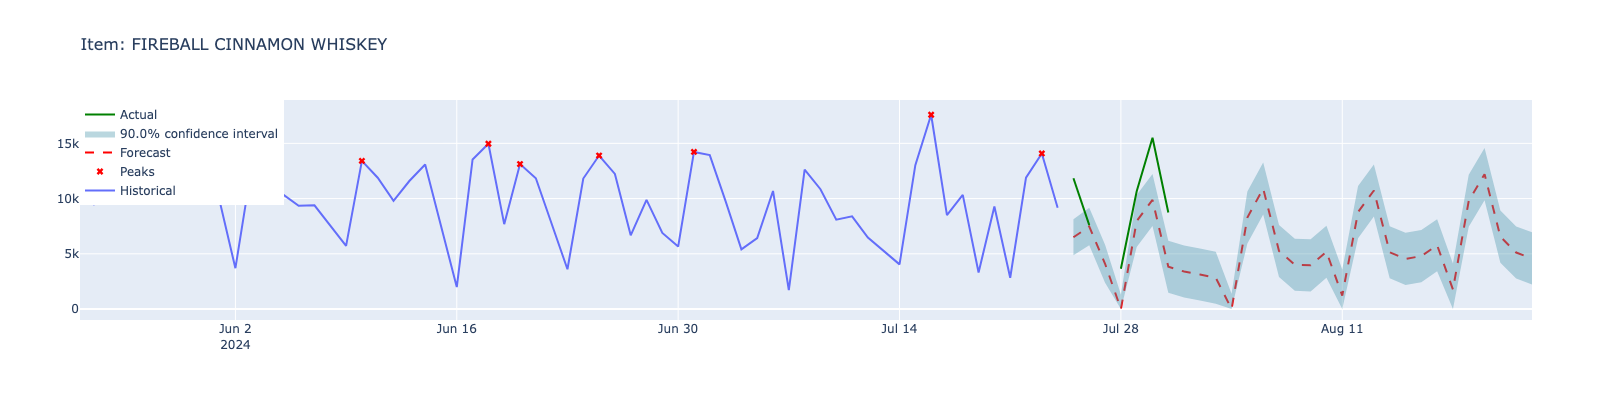

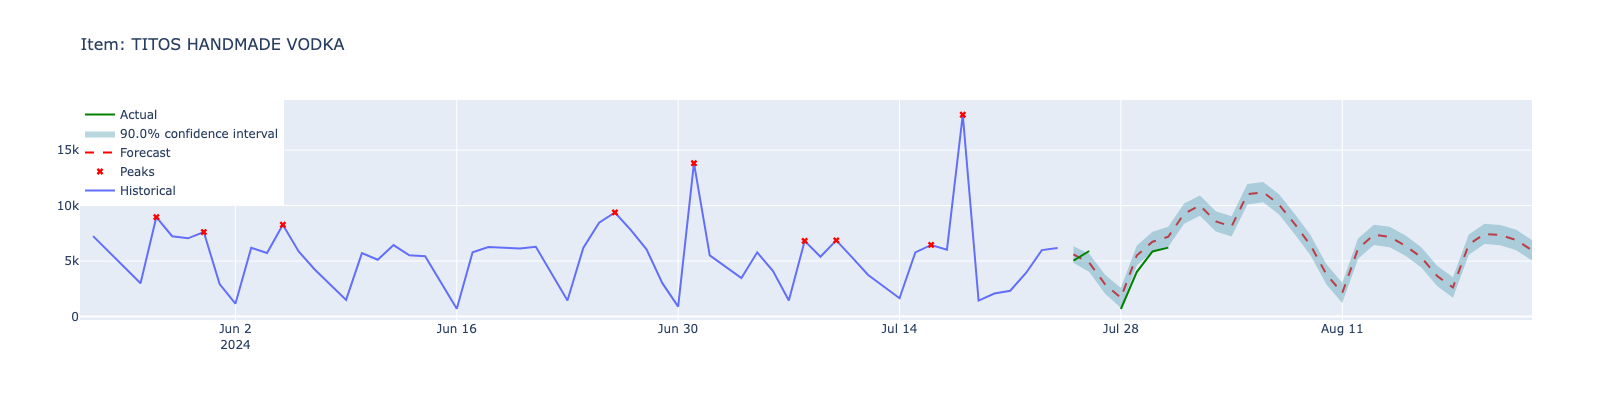

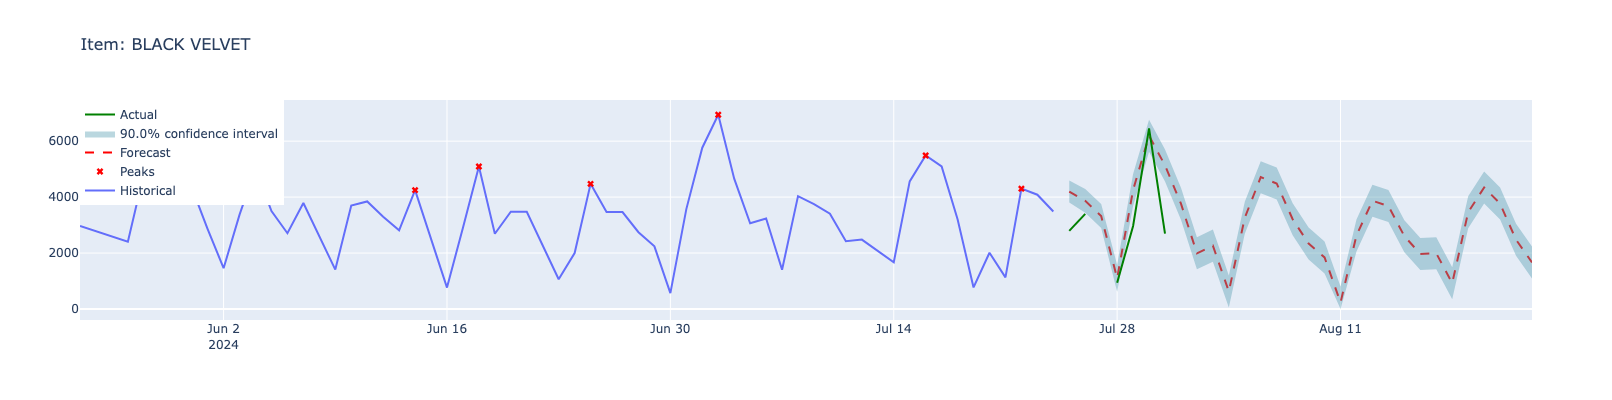

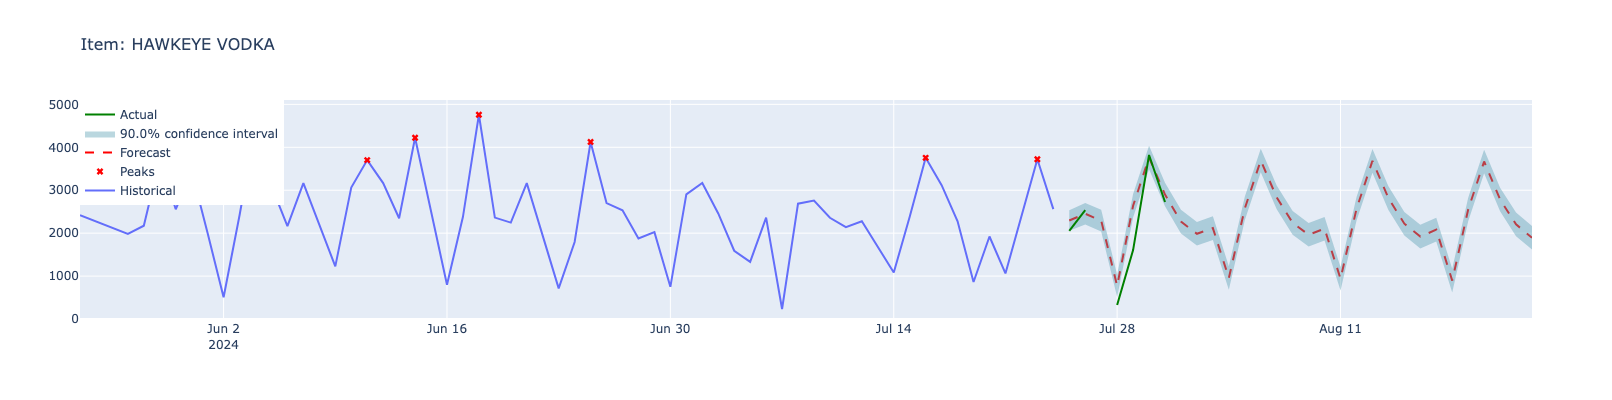

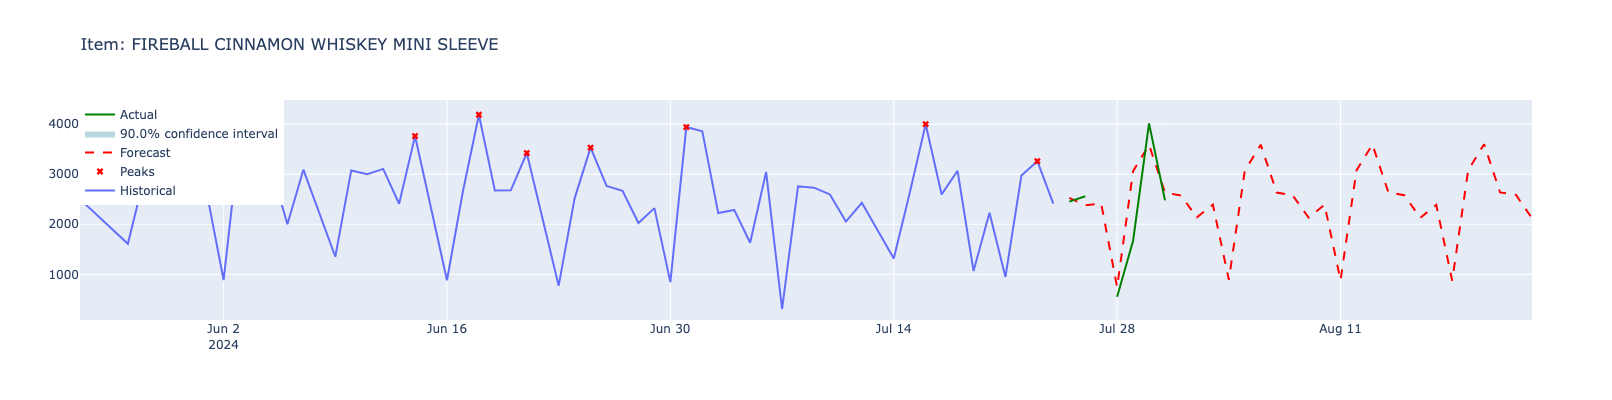

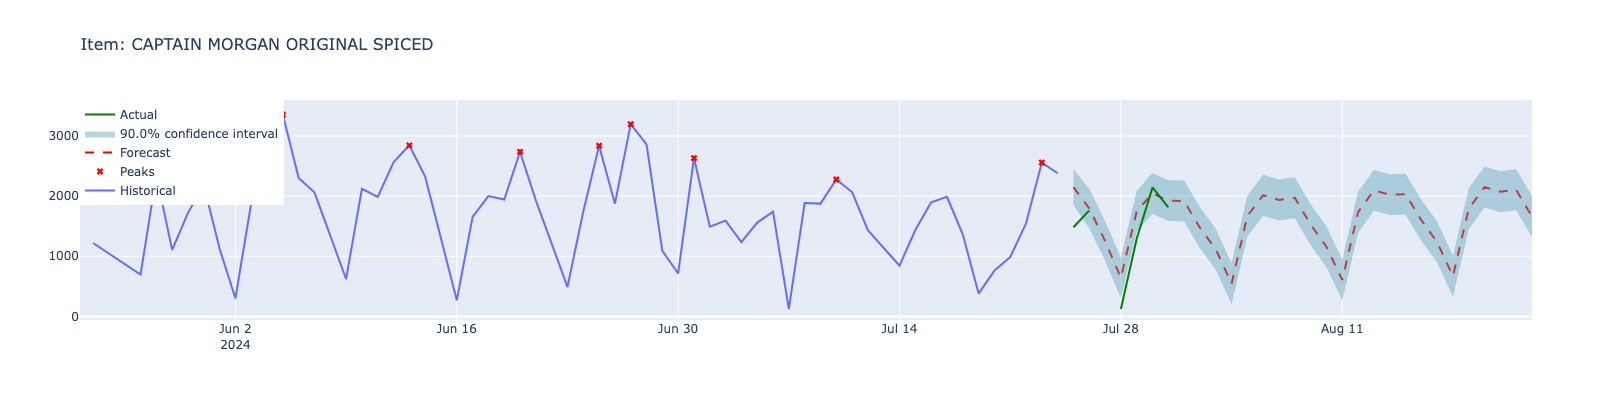

In [154]:
preds_dict  = multi_evaluate_predictions(client, items_list[:6], confidence_level=0.9, horizon=30)

for item_name, preds_info in preds_dict.items():
    actual_df = preds_info["train_df"].sort_values("date")
    predictions_df = preds_info["eval_df"].sort_values("date")

    plot_historical_and_forecast(
        input_timeseries=actual_df,
        timestamp_col_name="date",
        data_col_name="total_amount_sold",
        forecast_output=predictions_df,
        actual=predictions_df,
        title=f"Item: {item_name}",
        plotstartdate=(pd.to_datetime(END_DATE) - pd.DateOffset(months=2)).strftime("%Y-%m-%d"),
        prop={'size': 12},
        engine="plotly",
    )

In [29]:
explain_df = explain_model(client, item_name=items_list[0])
explain_df

I0000 00:00:1722966541.001604  348075 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual,holiday_effect_EasterMonday,holiday_effect_Halloween,holiday_effect_MardiGras,holiday_effect_StPatrickDay,holiday_effect_US_ColumbusDay,holiday_effect_US_ElectionDay,holiday_effect_US_IndependenceDay,holiday_effect_US_Juneteenth,holiday_effect_US_LaborDay,holiday_effect_US_MemorialDay,holiday_effect_US_MLKDay,holiday_effect_US_PresidentDay,holiday_effect_US_Superbowl,holiday_effect_VeteranDay,holiday_effect_Christmas,holiday_effect_MothersDay,holiday_effect_NewYear,holiday_effect_US_DaylightSavingEnd,holiday_effect_US_DaylightSavingStart,holiday_effect_US_Thanksgiving,holiday_effect_Valentine,attribution_item_name,attribution_avg_bottle_price,attribution_total_volume_sold_liters,attribution_total_sale_dollars,attribution_avg_bottle_cost,attribution_day_of_week,attribution_week_of_year,attribution_month,attribution_year,attribution_ma3_total_amount_sold,attribution_ma3_avg_bottle_price,attribution_ma3_total_sale_dollars,attribution_ma7_total_amount_sold,attribution_ma7_avg_bottle_price,attribution_ma7_total_sale_dollars,attribution_ma30_total_amount_sold,attribution_ma30_avg_bottle_price,attribution_ma30_total_sale_dollars,attribution_temperature,attribution_rainfall,attribution_snowfall,attribution_lag_1_total_amount_sold,attribution_lag_7_total_amount_sold,attribution___INTERCEPT__
0,2021-02-08 00:00:00+00:00,history,11603.000,11603.000,1024.040,NaN,NaN,NaN,0.000,NaN,NaN,NaN,587.676,NaN,0.000,0.000,0.000,169981.421,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-6767.983,-5452.742,12395.889,4631.332,423.685,-1272.190,-704.190,-30949948.225,12158.232,1345.862,-7767.582,-94.659,1987.145,430.706,220.095,478.360,-655.842,-24.324,205.734,-85.061,-1454.657,-104.569,30781088.886
1,2021-02-09 00:00:00+00:00,history,8272.000,9188.530,1024.040,NaN,NaN,NaN,170022.989,NaN,NaN,NaN,-426.926,NaN,0.000,0.000,0.000,-916.530,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-7420.894,-4477.556,10182.252,5072.412,635.528,-1272.190,-704.190,-30949948.225,11905.507,1334.727,-7620.793,-90.675,1976.741,420.029,217.321,477.402,-643.714,-26.318,139.989,-81.517,-1426.744,-145.511,30781088.886
2,2021-02-10 00:00:00+00:00,history,9765.000,11481.164,1024.040,NaN,NaN,NaN,169428.350,NaN,NaN,NaN,-1573.764,NaN,0.000,0.000,0.000,-1716.164,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-8981.511,-9123.520,20563.155,6142.437,847.371,-1272.190,-704.190,-30949948.225,11130.085,1350.037,-8763.641,-88.081,2039.165,456.866,214.684,478.839,-647.703,-28.300,121.741,-81.517,-1017.153,-150.655,30781088.886
3,2021-02-11 00:00:00+00:00,history,8650.000,5921.910,1024.040,NaN,NaN,NaN,168568.034,NaN,NaN,NaN,-868.308,NaN,0.000,0.000,0.000,2728.090,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-7293.497,-5252.183,11523.695,4982.562,1059.214,-1272.190,-704.190,-30949948.225,10021.211,1380.656,-8586.465,-87.443,2028.761,457.524,215.022,475.487,-642.799,-26.509,201.735,-81.517,-1200.737,-116.812,30781088.886
4,2021-02-12 00:00:00+00:00,history,11076.000,12326.422,1024.040,NaN,NaN,NaN,170468.651,NaN,NaN,NaN,476.041,NaN,1319.377,0.000,0.000,-1250.422,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1319.377,0.000,-7038.702,-5436.247,12549.180,4811.031,1271.056,-1272.190,-704.190,-30949948.225,11074.130,1358.388,-9067.277,-89.393,20

In [32]:
cols_order = explain_df.columns.difference(["time_series_timestamp"])
explain_df["weekday"] = explain_df["time_series_timestamp"].dt.day_name()
explain_df
# .to_clipboard()

,time_series_timestamp,weekday,attribution___INTERCEPT__,attribution_avg_bottle_cost,attribution_avg_bottle_price,attribution_day_of_week,attribution_item_name,attribution_lag_1_total_amount_sold,attribution_lag_7_total_amount_sold,attribution_ma30_avg_bottle_price,attribution_ma30_total_amount_sold,attribution_ma30_total_sale_dollars,attribution_ma3_avg_bottle_price,attribution_ma3_total_amount_sold,attribution_ma3_total_sale_dollars,attribution_ma7_avg_bottle_price,attribution_ma7_total_amount_sold,attribution_ma7_total_sale_dollars,attribution_month,attribution_rainfall,attribution_snowfall,attribution_temperature,attribution_total_sale_dollars,attribution_total_volume_sold_liters,attribution_week_of_year,attribution_year,confidence_level,holiday_effect,holiday_effect_Christmas,holiday_effect_EasterMonday,holiday_effect_Halloween,holiday_effect_MardiGras,holiday_effect_MothersDay,holiday_effect_NewYear,holiday_effect_StPatrickDay,holiday_effect_US_ColumbusDay,holiday_effect_US_DaylightSavingEnd,holiday_effect_US_DaylightSavingStart,holiday_effect_US_ElectionDay,holiday_effect_US_IndependenceDay,holiday_effect_US_Juneteenth,holiday_effect_US_LaborDay,holiday_effect_US_MLKDay,holiday_effect_US_MemorialDay,holiday_effect_US_PresidentDay,holiday_effect_US_Superbowl,holiday_effect_US_Thanksgiving,holiday_effect_Valentine,holiday_effect_VeteranDay,prediction_interval_lower_bound,prediction_interval_upper_bound,residual,seasonal_period_daily,seasonal_period_monthly,seasonal_period_quarterly,seasonal_period_weekly,seasonal_period_yearly,spikes_and_dips,standard_error,step_changes,time_series_adjusted_data,time_series_data,time_series_type,trend
0,2021-02-08 00:00:00+00:00,Monday,30781088.886,4631.332,-6767.983,423.685,0.000,-1454.657,-104.569,478.360,220.095,-655.842,1345.862,12158.232,-7767.582,1987.145,-94.659,430.706,-704.190,205.734,-85.061,-24.324,12395.889,-5452.742,-1272.190,-30949948.225,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,169981.421,NaN,NaN,NaN,587.676,NaN,0.000,1024.040,0.000,11603.000,11603.000,history,0.000
1,2021-02-09 00:00:00+00:00,Tuesday,30781088.886,5072.412,-7420.894,635.528,0.000,-1426.744,-145.511,477.402,217.321,-643.714,1334.727,11905.507,-7620.793,1976.741,-90.675,420.029,-704.190,139.989,-81.517,-26.318,10182.252,-4477.556,-1272.190,-30949948.225,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,-916.530,NaN,NaN,NaN,-426.926,NaN,0.000,1024.040,0.000,9188.530,8272.000,history,170022.989
2,2021-02-10 00:00:00+00:00,Wednesday,30781088.886,6142.437,-8981.511,847.371,0.000,-1017.153,-150.655,478.839,214.684,-647.703,1350.037,11130.085,-8763.641,2039.165,-88.081,456.866,-704.190,121.741,-81.517,-28.300,20563.155,-9123.520,-1272.190,-30949948.225,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,-1716.164,NaN,NaN,NaN,-1573.764,NaN,0.000,1024.040,0.000,11481.164,9765.000,history,169428.350
3,2021-02-11 00:00:00+00:00,Thursday,30781088.886,4982.562,-7293.497,1059.214,0.000,-1200.737,-116.812,475.487,215.022,-642.799,1380.656,10021.211,-8586.465,2028.761,-87.443,457.524,-704.190,201.735,-81.517,-26.509,11523.695,-5252.183,-1272.190,-30949948.225,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,2728.090,NaN,NaN,NaN,-868.308,NaN,0.000,1024.040,0.000,5921.910,8650.000,history,168568.034
4,2021-02-12 00:00:00+00:00,Friday,30781088.886,4811.031,-7038.702,1271.056,0.000,-1063.633,-121.867,473.093,213.496,-637.752,1358.388,11074.130,-9067.277,2010.034,-89.393,457.099,-704.190,239.357,-81.517,-22.401,12549.180,-5436.247,-1272.190,-30949948.225,NaN,1319.377,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

In [34]:
explain_df[["time_series_timestamp", "weekday", "time_series_type", "time_series_adjusted_data", "seasonal_period_weekly", "standard_error", "step_changes", "trend"]].tail(40)

,time_series_timestamp,weekday,time_series_type,time_series_adjusted_data,seasonal_period_weekly,standard_error,step_changes,trend
1061,2024-01-05 00:00:00+00:00,Friday,history,12294.906,-427.649,1024.040,0.000,213427.276
1062,2024-01-06 00:00:00+00:00,Saturday,history,NaN,-239.098,1024.040,0.000,213761.463
1063,2024-01-07 00:00:00+00:00,Sunday,history,1909.824,18.361,1024.040,0.000,213726.114
1064,2024-01-08 00:00:00+00:00,Monday,history,11283.886,832.455,1024.040,0.000,213765.679
1065,2024-01-09 00:00:00+00:00,Tuesday,history,9526.799,140.657,1024.040,0.000,213513.699
1066,2024-01-10 00:00:00+00:00,Wednesday,history,11854.166,-324.601,1024.040,0.000,213820.549
1067,2024-01-11 00:00:00+00:00,Thursday,history,10032.825,36.632,1024.040,0.000,213960.575
1068,2024-01-12 00:00:00+00:00,Friday,history,6016.053,-701.220,1024.040,0.000,214161.846
1069,2024-01-13 00:00:00+00:00,Saturday,history,NaN,-337.104,1024.040,0.000,213129.438
1070,2024-01-14 00:00:00+00:00,Sunday,history,7384.410,21.415,1024.040,0.000,213924.045


In [129]:
actual_df, forecast_df = evaluate_predictions(client, item_name="FIREBALL CINNAMON WHISKEY", end_date=END_DATE, horizon=7)

I0000 00:00:1723054499.927119  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723054503.339066  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723054507.486057  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [130]:
actual_df

,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold
0,2021-07-26,FIREBALL CINNAMON WHISKEY,7926.000,8.500,1579.400,5.660,2,30,7,2021,9919.670,9.150,8090.290,8.350,8974.500,9.430,74.790,3.720,0.000,11750,11193
1,2021-07-27,FIREBALL CINNAMON WHISKEY,11604.000,9.870,2229.500,6.580,3,30,7,2021,10426.670,9.520,9734.290,9.230,8981.600,9.430,75.040,4.480,0.000,7926,96
2,2021-07-28,FIREBALL CINNAMON WHISKEY,9014.000,8.960,1652.450,5.970,4,30,7,2021,9514.670,9.110,10034.000,9.210,8883.000,9.440,76.310,7.090,0.000,11604,6916
3,2021-07-29,FIREBALL CINNAMON WHISKEY,9223.000,10.070,2362.850,6.710,5,30,7,2021,9947.000,9.630,9863.290,9.420,8937.270,9.450,75.930,7.080,0.000,9014,10418
4,2021-07-30,FIREBALL CINNAMON WHISKEY,13095.000,8.920,2478.550,5.950,6,30,7,2021,10444.000,9.320,10385.000,9.330,9082.970,9.440,73.600,9.690,0.000,9223,9443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,2024-07-20,FIREBALL CINNAMON WHISKEY,9284.000,6.770,1501.690,4.510,7,28,7,2024,7645.000,7.370,9441.430,7.440,9265.570,7.770,71.590,9.700,0.000,3312,6464
865,2024-07-21,FIREBALL CINNAMON WHISKEY,2833.000,8.610,649.520,5.740,1,29,7,2024,5143.000,7.770,9268.860,7.560,9103.900,7.800,72.310,8.160,0.000,9284,4041
866,2024-07-22,FIREBALL CINNAMON WHISKEY,11898.000,7.120,1978.010,4.740,2,29,7,2024,8005.000,7.500,9107.430,7.560,9062.930,7.780,71.930,10.570,0.000,2833,13028
867,2024-07-23,FIREBALL CINNAMON WHISKEY,14086.000,7.280,2448.450,4.850,3,29,7,2024,9605.670,7.670,8606.570,7.620,9137.830,7.760,72.770,8.980,0.000,11898,17592


In [131]:
forecast_df

,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_level
0,2024-07-25,FIREBALL CINNAMON WHISKEY,11845.000,6.700,2029.060,4.470,5,29,7,2024,11701.670,7.400,8918.860,7.520,9324.600,7.740,74.150,8.580,0.000,9174,10339,6497.420,5232.348,7762.491,0.800
1,2024-07-26,FIREBALL CINNAMON WHISKEY,7598.000,8.490,1684.030,5.660,6,29,7,2024,9539.000,7.810,9531.140,7.600,9114.630,7.770,73.500,7.280,0.000,11845,3312,7468.139,6140.096,8796.182,0.800
2,2024-07-27,FIREBALL CINNAMON WHISKEY,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,4094.117,2753.306,5434.928,0.800
3,2024-07-28,FIREBALL CINNAMON WHISKEY,3651.000,6.030,474.270,4.020,1,30,7,2024,7698.000,7.080,8726.430,7.490,8828.670,7.710,73.150,8.090,0.000,7598,9284,-656.500,-2185.649,872.650,0.800
4,2024-07-29,FIREBALL CINNAMON WHISKEY,10660.000,6.580,1935.240,4.380,2,30,7,2024,7303.000,7.030,9844.570,7.200,8961.500,7.590,73.800,11.420,0.000,3651,2833,7962.549,6125.261,9799.837,0.800
5,2024-07-30,FIREBALL CINNAMON WHISKEY,15508.000,7.420,2813.590,4.950,3,30,7,2024,9939.670,6.680,10360.290,7.250,9149.030,7.600,74.620,10.650,0.000,10660,11898,9878.847,8041.287,11716.407,0.800
6,2024-07-31,FIREBALL CINNAMON WHISKEY,8743.000,8.370,1931.740,5.580,4,30,7,2024,11637.000,7.450,9597.000,7.400,9211.000,7.580,75.280,11.860,0.000,15508,14086,3829.778,1991.946,5667.610,0.800


In [123]:
END_DATE

'2024-07-24'

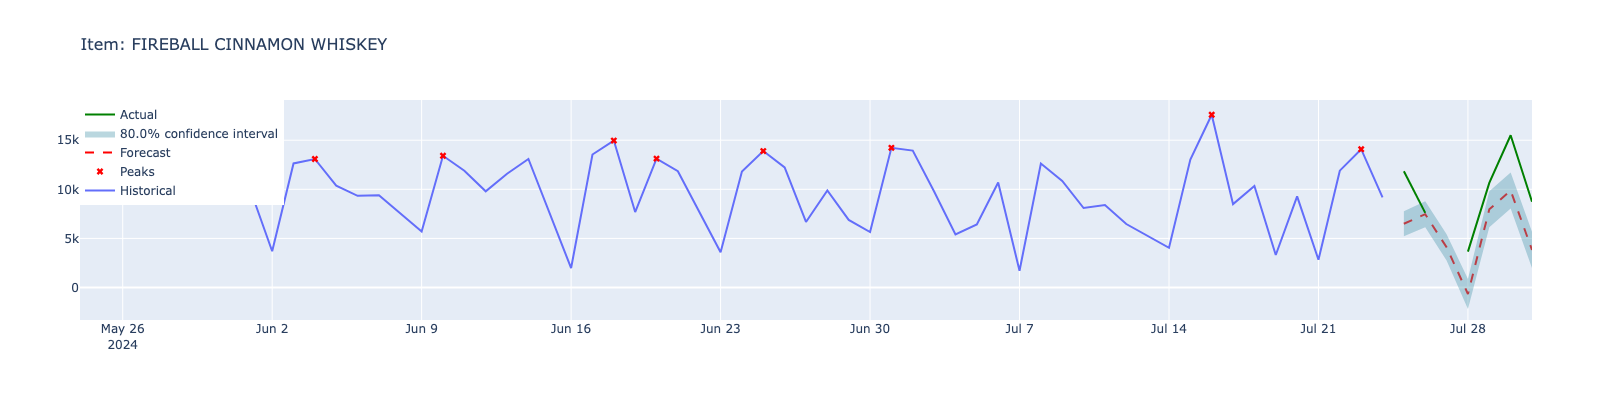

In [132]:
item_name = "FIREBALL CINNAMON WHISKEY"
plot_historical_and_forecast(
    input_timeseries=actual_df,
    timestamp_col_name="date",
    data_col_name="total_amount_sold",
    forecast_output=forecast_df,
    actual=forecast_df,
    title=f"Item: {item_name}",
    plotstartdate=(pd.to_datetime(END_DATE) - pd.DateOffset(months=2)).strftime("%Y-%m-%d"),
    prop={'size': 12},
    engine="plotly",
)

In [35]:
from pycaret.regression import *

In [ ]:
s = setup(
    data=df_train,
    target="total_amount_sold",
    # categorical_features=["item_name"],
    # polynomial_features=True,
    remove_multicollinearity=True,
    remove_outliers=True,
    transformation=True,
    normalize=True,
    normalize_method="robust",
    # data_split_stratify=True,
)

In [ ]:
best = compare_models()